In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = {# U_L/du
0.2:[0.320878628692,0.014354985748],
0.4:[0.28759238955,0.0173941871764],
0.8:[0.179652184681,0.012733736384],
1.2:[0.152164204092,0.0106738755021],
1.6:[0.144804252876,0.00974592070867],
2.0:[0.142805206381,0.0110827643436],
}

du_s7 = {
0.2:[0.212809887078,0.0174258713457],
0.8:[0.191486082107,0.0119116965823],
2.0:[0.137051163804,0.0110047225507],
}

U_L = {}
for key in du.keys():
    U_L[key] = key*du[key][0]
U_L_s7 = {}
for key in du_s7.keys():
    U_L_s7[key] = key*du_s7[key][0]

def get_data(f):
    dat = np.fromfile(f,sep=' ')
    n = np.size(dat)
    dat = np.reshape(dat,[int(n/6.),6])
    ubar = dat[:,0]
    vbar = dat[:,1]
    utilde = dat[:,2]
    vtilde = dat[:,3]
    ru = dat[:,4]
    rv = dat[:,5]
    return ubar,vbar,utilde,vtilde,ru,rv

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/'
directory = '/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"heatflux*dat")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['heatflux_0000.dat', 'heatflux_0001.dat', 'heatflux_0002.dat', 'heatflux_0003.dat', 'heatflux_0004.dat', 'heatflux_0005.dat', 'heatflux_0006.dat', 'heatflux_0007.dat', 'heatflux_0008.dat', 'heatflux_0009.dat', 'heatflux_0010.dat', 'heatflux_0011.dat', 'heatflux_0012.dat', 'heatflux_0013.dat']


0.2: [1.00181521361,2.71967570496e-05],
0.4: [1.00794826614,0.000591726491693],
0.8: [1.02227703008,0.00562065883949],
1.2: [1.06623838842,0.0115040901092],
1.6: [1.11716963564,0.0248225652021],
2.0: [1.24112277561,0.0308264597228],
0.2: [6.9307978683e-05,6.19053719139e-06],
0.4: [0.000579622893824,0.000349652265368],
0.8: [0.00502038157869,0.00108907368914],
1.2: [0.0169700666235,0.00280069318703],
1.6: [0.0317284560948,0.00656833730053],
2.0: [0.0648225952906,0.0154835706647],


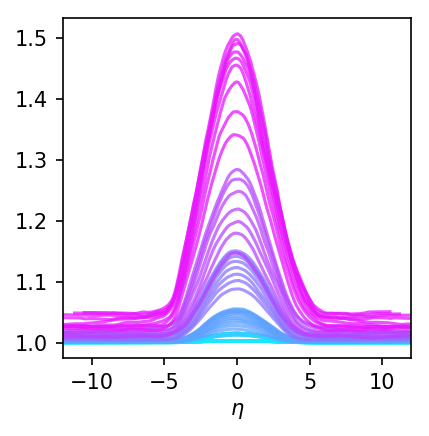

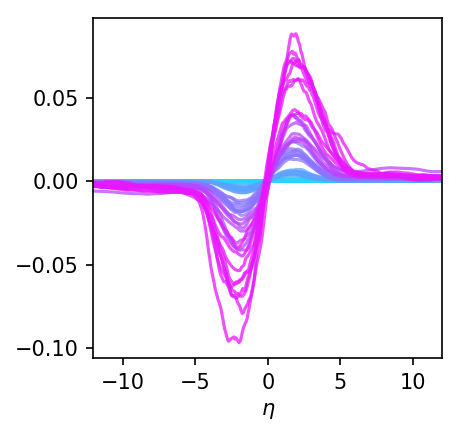

In [31]:
s = '1'
# Mc_list = ['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)

for comp in ['T','v']:
    fig = plt.figure(figsize=(3,3),dpi=150)
    for i,Mc in enumerate(Mc_list):
        directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)

        flist = glob.glob(directory+"heatflux*")
        flist.sort()
        #     mat = np.zeros([1,len(flist),100])
        #     eta_plot = np.linspace(-20,20,100)

        if Mc=='02': ist = 10;ien=None
        elif Mc=='04': ist = 5;ien=None
        elif Mc=='08': ist = 5;ien=-1
        elif Mc=='12': ist = 5;ien=None
        elif Mc=='16': ist = 3;ien=-1
        elif Mc=='20': ist = 5;ien=None
        else: ist=0;ien = -1
        mat = np.zeros([len(flist[ist:ien])])
     
        colorVal = scalarMap.to_rgba(inp.Mc)
        for j,fname in enumerate(flist[ist:ien]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            dtheta = get_dtheta(directory,time)
            eta = y/dtheta
            
            # Get y lscale
            autocorr = np.fromfile(directory+'lscale_vv_%04d.dat'%tID,sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=0.2)

            scale = 1./(U_L[inp.Mc]*(ly/dtheta)**2)
            Tbar,vbar,Ttilde,vtilde,vT,tmp = get_data(fname)
            if comp=='T': fplot = Ttilde
            if comp=='v': fplot = vT*scale
            if j==0: plt.plot(eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
            else: plt.plot(eta,fplot,alpha=0.75,color=colorVal)
            mat[j] = 0.5*(abs(min(fplot))+abs(max(fplot))) # avg of peak magnitudes

        
        mn = np.mean(mat,axis=0)
        std = np.std(mat,axis=0)
        print('{}: [{},{}],'.format(inp.Mc,mn,std))
#     mn = np.mean(mat[0,:,:],axis=0)
#     std = np.std(mat[0,:,:],axis=0)
#     plt.plot(eta_plot,mn,color='C%i'%i)
#     plt.fill_between(eta_plot, mn-std, mn+std, color='C%i'%i, alpha=0.2)

    plt.xlim([-12,12])
    plt.xlabel(r'$\eta$')
#     plt.ylabel(r"$\overline{\rho'%s'}$"%comp)
# plt.legend(fontsize=9)

In [34]:
# Scaled by dU
vT = {
0.2: [7.1427166286e-05,3.79220916884e-06],
0.4: [0.000259033227909,3.72983552993e-05],
0.8: [0.000518040248281,8.76142505714e-05],
1.2: [0.00124107034491,8.21330177708e-05],
1.6: [0.00204483335589,0.000336598740405],
2.0: [0.00333769317235,0.000298690340898]
}

In [ ]:
# Scaled by U_delta
vT = {
0.2: [6.9307978683e-05,6.19053719139e-06],
0.4: [0.000579622893824,0.000349652265368],
0.8: [0.00502038157869,0.00108907368914],
1.2: [0.0169700666235,0.00280069318703],
1.6: [0.0317284560948,0.00656833730053],
2.0: [0.0648225952906,0.0154835706647],
}

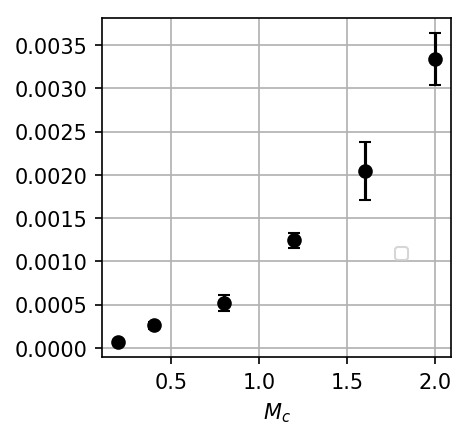

In [35]:
def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(vT,'ko',r'')

plt.xlabel('$M_c$')
plt.grid(True)
# plt.ylim([-0.9,0.9])
# plt.ylim([-.023,0.023])
plt.legend(fontsize=8,bbox_to_anchor=(0.9,0.35))